In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("datos/bikes_stand.csv", index_col=0)
df.head(5)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered
0,2018-01-01,winter,0,1,1,Monday,0,2,-0.486274,0.855582,-0.208909,654
1,2018-01-02,winter,0,1,0,Tuesday,1,2,-0.425690,0.332722,0.687550,670
2,2018-01-03,winter,0,1,0,Wednesday,1,1,-0.949970,-0.900337,0.685210,1229
3,2018-01-04,winter,0,1,0,Thursday,1,1,-0.938563,-0.170632,-0.210435,1454
4,2018-01-05,winter,0,1,0,Friday,1,1,-0.853992,-0.901843,0.060294,1518


In [3]:
lista_categoricas = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [4]:
df["season_encoding"] = df["season"].map({"winter": 1, "autumn": 2, "spring": 2, "summer": 2})
df['mnth_encoding'] = df['mnth'].map({1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 11:2, 12:2 })
df['holiday_encoding'] = df['holiday'].map({0:1, 1:0})
df['weekday_encoding'] = df['weekday'].map({'Monday':1, 'Tuesday':1, 'Wednesday':2, 'Thursday':2, 'Friday':2, 'Saturday':2, 'Sunday':2})
df['weathersit_encoding'] = df['weathersit'].map({1:3, 2:2.5, 3:1})

In [5]:
oh = OneHotEncoder()
transformados_wd = oh.fit_transform(df[["workingday"]])
oh_df = pd.DataFrame(transformados_wd.toarray())
oh_df.columns = oh.get_feature_names_out()
df = pd.concat([df,oh_df],axis=1)

In [6]:
df.drop(columns=['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'], inplace=True)

In [7]:
df.head(1)

,temp,hum,windspeed,registered,season_encoding,mnth_encoding,holiday_encoding,weekday_encoding,weathersit_encoding,workingday_0,workingday_1
0,-0.486274,0.855582,-0.208909,654,1,1,0,1,2.5,1.0,0.0


In [8]:
X = df.drop("registered", axis = 1)
y = df["registered"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)

In [10]:
arbol = DecisionTreeRegressor(random_state = 23)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=23)

In [11]:
# fig = plt.figure(figsize = (10,6))
# tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
# plt.show()

In [12]:
max_features = np.sqrt(len(x_train.columns))
max_features

3.1622776601683795

In [13]:
print(arbol.tree_.max_depth)

20


In [14]:
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [15]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [56]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1227.15847,2.483905e+06,1576.040883,-0.152943,test,Decision Tree I
1,0.00000,0.000000e+00,0.000000,1.000000,train,Decision Tree I


In [17]:
param = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10], 
        "max_features": [1,2,3],
        "min_samples_split": [10, 50, 150, 200, 250, 300, 350, 400],
        "min_samples_leaf": [10, 50, 150, 200, 250, 300, 350, 400]} 

In [18]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [19]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 150, 200, 250, 300, 350,
                                              400],
                         'min_samples_split': [10, 50, 150, 200, 250, 300, 350,
                                               400]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [20]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

In [21]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [22]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,995.914781,1.385607e+06,1177.117927,0.356849,test,Decision tree II
1,891.220616,1.143624e+06,1069.403422,0.544579,train,Decision tree II


In [57]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1227.158470,2.483905e+06,1576.040883,-0.152943,test,Decision Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decision Tree I
0,995.914781,1.385607e+06,1177.117927,0.356849,test,Decision tree II
1,891.220616,1.143624e+06,1069.403422,0.544579,train,Decision tree II


In [24]:
param2 = {"max_depth": [4, 5, 6, 7, 8, 9], 
        "max_features": [1,2,3,4],
        "min_samples_split": [5, 10, 20, 50, 150, 200],
        "min_samples_leaf": [5, 10, 20, 50, 150, 200]} 

In [25]:
gs2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param2, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [26]:
gs2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 150, 200],
                         'min_samples_split': [5, 10, 20, 50, 150, 200]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [27]:
mejor_modelo2 = gs2.best_estimator_
mejor_modelo2

DecisionTreeRegressor(max_depth=9, max_features=4, min_samples_leaf=10,
                      min_samples_split=50)

In [28]:
y_pred_test_dt3 = mejor_modelo2.predict(x_test)
y_pred_train_dt3 = mejor_modelo2.predict(x_train)

In [58]:
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,948.839564,1.231017e+06,1109.511936,0.428605,test,Decision tree III
1,950.270073,1.280594e+06,1131.633506,0.490034,train,Decision tree III


In [59]:
df_decision_results = pd.concat([df_decision_results, dt_results3], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1227.158470,2.483905e+06,1576.040883,-0.152943,test,Decision Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decision Tree I
0,995.914781,1.385607e+06,1177.117927,0.356849,test,Decision tree II
1,891.220616,1.143624e+06,1069.403422,0.544579,train,Decision tree II
0,948.839564,1.231017e+06,1109.511936,0.428605,test,Decision tree III
1,950.270073,1.280594e+06,1131.633506,0.490034,train,Decision tree III


In [37]:
bosque = RandomForestRegressor(max_depth=9, max_features=4, min_samples_leaf=10,
                      min_samples_split=50, random_state = 23)
bosque.fit(x_train, y_train)
                

RandomForestRegressor(max_depth=9, max_features=4, min_samples_leaf=10,
                      min_samples_split=50, random_state=23)

In [38]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [39]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,949.973173,1.199854e+06,1095.378564,0.443069,test,Random Forest
1,932.088500,1.176216e+06,1084.535124,0.531600,train,Random Forest


In [60]:
results = pd.concat([df_decision_results, rf_results], axis = 0)
results

,MAE,MSE,RMSE,R2,set,modelo
0,1227.158470,2.483905e+06,1576.040883,-0.152943,test,Decision Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decision Tree I
0,995.914781,1.385607e+06,1177.117927,0.356849,test,Decision tree II
1,891.220616,1.143624e+06,1069.403422,0.544579,train,Decision tree II
0,948.839564,1.231017e+06,1109.511936,0.428605,test,Decision tree III
1,950.270073,1.280594e+06,1131.633506,0.490034,train,Decision tree III
0,949.973173,1.199854e+06,1095.378564,0.443069,test,Random Forest
1,932.088500,1.176216e+06,1084.535124,0.531600,train,Random Forest


In [41]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [42]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 150, 200, 250, 300, 350,
                                              400],
                         'min_samples_split': [10, 50, 150, 200, 250, 300, 350,
                                               400]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [43]:
bosque2 = gs_rf.best_estimator_
bosque2

RandomForestRegressor(max_depth=8, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

In [44]:
y_pred_test_rf2 = bosque2.predict(x_test)
y_pred_train_rf2 = bosque2.predict(x_train)

In [61]:

dt_results_rf2 = metricas(y_test, y_train, y_pred_test_rf2, y_pred_train_rf2, "Random Forest II")
dt_results_rf2

,MAE,MSE,RMSE,R2,set,modelo
0,944.627110,1.174625e+06,1083.801239,0.454780,test,Random Forest II
1,892.008138,1.069376e+06,1034.106462,0.574147,train,Random Forest II


In [46]:
gs_rf2 = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param2, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [47]:
gs_rf2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 150, 200],
                         'min_samples_split': [5, 10, 20, 50, 150, 200]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [53]:
bosque3 = gs_rf2.best_estimator_
bosque3

RandomForestRegressor(max_depth=8, max_features=4, min_samples_leaf=5,
                      min_samples_split=10)

In [54]:
y_pred_test_rf3 = bosque3.predict(x_test)
y_pred_train_rf3 = bosque3.predict(x_train)

In [67]:
dt_results_rf3 = metricas(y_test, y_train, y_pred_test_rf3, y_pred_train_rf3, "Random Forest III")
dt_results_rf3

,MAE,MSE,RMSE,R2,set,modelo
0,925.813968,1.134579e+06,1065.166389,0.473368,test,Random Forest III
1,779.135531,8.267856e+05,909.277490,0.670753,train,Random Forest III


In [66]:
results = pd.concat([results, dt_results_rf2, dt_results_rf3], axis = 0)
results

,MAE,MSE,RMSE,R2,set,modelo
0,1227.158470,2.483905e+06,1576.040883,-0.152943,test,Decision Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decision Tree I
0,995.914781,1.385607e+06,1177.117927,0.356849,test,Decision tree II
1,891.220616,1.143624e+06,1069.403422,0.544579,train,Decision tree II
0,948.839564,1.231017e+06,1109.511936,0.428605,test,Decision tree III
1,950.270073,1.280594e+06,1131.633506,0.490034,train,Decision tree III
0,949.973173,1.199854e+06,1095.378564,0.443069,test,Random Forest
1,932.088500,1.176216e+06,1084.535124,0.531600,train,Random Forest
0,944.627110,1.174625e+06,1083.801239,0.454780,test,Random Forest II
1,892.008138,1.069376e+06,1034.106462,0.574147,train,Random Forest II


In [52]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [68]:

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque3.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,temp,0.392245
3,season_encoding,0.180311
1,hum,0.162309
2,windspeed,0.104912
4,mnth_encoding,0.080362
6,weekday_encoding,0.037273
7,weathersit_encoding,0.029436
8,workingday_0,0.007082
9,workingday_1,0.004350
5,holiday_encoding,0.001720


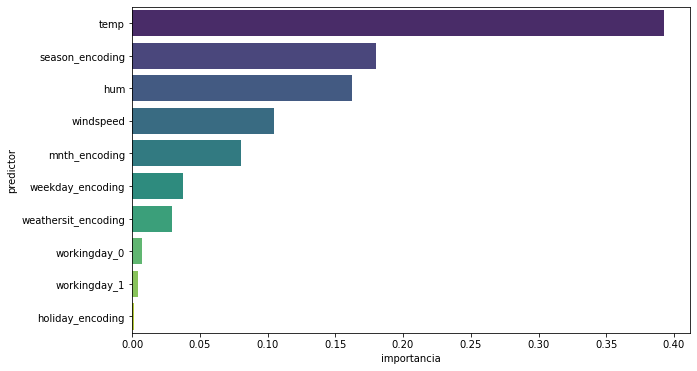

In [69]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()